In [1]:
import networkx as nx 
import numpy as np 
import matplotlib.pyplot as plt

from src import helperfunctions as hf
from src import MonteCarloIsing as mci

In [2]:
sizes = [50,50] # sizes of blocks
probs = [[0.2, 0.05], [0.05, 0.05]]
G = nx.stochastic_block_model(sizes, probs, seed=0)


#G.graph['partition'][1] get nodes from 2nd stochastic block

J = nx.to_numpy_matrix(G)


def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)



In [3]:
import torch
class mf_ising_system:

    def __init__(self,graph,background_field,fixed_point_iter=int(5*1e4),init_mag='aligned',fp_tol_fac=10-6,
        iim_iter=1000,step_size=1.0,iim_tol_fac=1e-7,optimiser_type='sgd',momentum=0.4):
        
        self.graph = graph
        self.adj_matrix = torch.from_numpy(nx.to_numpy_matrix(graph))
        self.graph_size = len(graph.nodes.keys())
        self.background_field = background_field
        self.fixed_point_iter=fixed_point_iter
        self.iim_iter = iim_iter
        self.fp_tol_fac=fp_tol_fac
        self.iim_tol_fac=iim_tol_fac
        self.optimiser_type = optimiser_type
        self.momentum = momentum
        self.step_size=step_size
        if init_mag=='aligned':
            self.init_mag=torch.ones(self.graph_size,dtype=torch.float64)
        elif init_mag=='random':
            self.init_mag=torch.Tensor([np.random.choice([-1,1]) for i in range(self.graph_size)],dtype=torch.float64)
        else:
            self.init_mag = init_mag 
            
        
    def single_mag(self,i,m,beta,field):
        gamma=1.0
        spin_field = torch.dot(self.adj_matrix[i],m) 
        term = torch.tanh(beta*(spin_field+field[i]))
        return (1.0-gamma)*m[i] + gamma*term
    
    def magnetisation(self,mag,beta,field):
        m_old = mag
        m_new = torch.zeros(len(m_old),dtype=torch.float64)
        for i in range(self.graph_size):
            m_new[i]=self.single_mag(i,m_old,beta,field)
        return m_new


    def sgdm(self,H,changes,it):
        new_change = self.step_size * H.grad.data + self.momentum * changes[it]
        H.data.add_(new_change)
        changes.append(new_change)
        return H,changes
    

    def MF_IIM(self,H,field_budget,beta):
              

        control_field = H.data
        self.control_field_history=[]
        self.control_field_history.append(control_field)
        self.mag_delta_history =[]
        
        changes = [np.zeros(self.graph_size)]
        previous_mag = self.init_mag
        self.mag_delta_history.append(previous_mag)
        for it in range(self.iim_iter):
            mag= self.magnetisation(previous_mag,beta,H)
            self.mag_delta_history.append(mag)

            mag.backward(torch.ones_like(H),retain_graph=True)

            if self.optimiser_type=='sgd':
                control_field_update = H.data.add_(self.step_size * H.grad.data)
            elif self.optimiser_type =='sgdm':
                control_field_update,changes = self.sgdm(H,changes,it)

            H.data= hf.projection_simplex_sort_torch(H,z=field_budget)
            H.grad.detach_()
            H.grad.zero_()
            
            mag_ii = self.mag_delta_history[-1]
            mag_i=self.mag_delta_history[-2]
            previous_mag = mag
            if torch.abs(torch.mean(mag_ii)-torch.mean(mag_i)) <= self.iim_tol_fac:
                final_mag=mag_ii
                break
            h_arr = H.detach().numpy()
            self.control_field_history.append(h_arr)
        if it==self.iim_iter-1:
            print('Failed to converge after {} iterations'.format(self.iim_iter))
            final_mag = mag_ii
            
        return H.detach().numpy(),final_mag.detach().numpy()
            

In [5]:
        
                
budget=20.0
b = torch.zeros(len(G.nodes.keys()),dtype=torch.float64)



system = mf_ising_system(G,b,iim_iter=1000,fixed_point_iter=int(5*1e4),iim_tol_fac=1e-7)
beta_crit=hf.crit_b(system.adj_matrix)

H=(budget/system.graph_size)*torch.ones(system.graph_size,dtype=torch.float64)

H.requires_grad=True
H,mag=system.MF_IIM(H,budget,2.8)




[0.19724868 0.19724868 0.19724868 0.19724868 0.19724868 0.19724868
 0.19724868 0.19724868 0.19724868 0.19724868 0.19724868 0.19724868
 0.19724868 0.19724868 0.19724868 0.19724868 0.19724868 0.19724868
 0.19724868 0.19724868 0.19724868 0.19724868 0.19724868 0.19724868
 0.19724868 0.19724868 0.19724868 0.19724868 0.19724868 0.19724868
 0.19724868 0.19724868 0.19724868 0.19724868 0.19724868 0.19724868
 0.19724868 0.19724868 0.19724868 0.19724868 0.19724868 0.19724868
 0.19724868 0.19724868 0.19724868 0.19724868 0.19724868 0.19724868
 0.19724868 0.19724868 0.19724871 0.19724871 0.19725707 0.19725707
 0.19724868 0.19724868 0.19724871 0.19724868 0.19724871 0.4655038
 0.19724868 0.19725707 0.19725707 0.19724871 0.19724868 0.19724871
 0.19724868 0.19724868 0.19724868 0.19950448 0.19724868 0.19725707
 0.19724871 0.19724871 0.19725707 0.19724871 0.19724871 0.19724868
 0.19724871 0.19724868 0.19724868 0.19724868 0.19724868 0.19725707
 0.19725707 0.19724868 0.19724868 0.19950448 0.19724871 0.19724

In [6]:
block1,block2 = np.sum(H[:50]),np.sum(H[50:])
print(block1,block2)


9.862433995162323 10.137566004837659


In [12]:
import time
start_time = time.time()

budget=20.0


beta_min = 0.5*beta_crit 
beta_max = 3*beta_crit 

beta_list = np.logspace(np.log10(beta_min),np.log10(beta_max),num=100,endpoint=True,base=10)
y = np.zeros(len(beta_list))
control_history=np.zeros((len(beta_list),2))

iters=1
runs = np.zeros((iters,len(beta_list),2))



normal_params = {'graph':G,'background_field':b,
                         'iim_iter':5000,'iim_tol_fac':1e-7,'fixed_point_iter':5000,
                         'step_size':1.75,'fp_tol_fac':10-6}

for it in range(iters):
    print('iteration',it)
    system = mf_ising_system(**normal_params)
    H=(budget/system.graph_size)*torch.ones(system.graph_size,dtype=torch.float64)
    H.requires_grad=True
    for i,beta in enumerate(beta_list):
        control,_=system.MF_IIM(H,budget,beta)
        block1,block2 = np.sum(control[:50]),np.sum(control[50:])
        runs[it,i,:]=np.array([block1,block2])
        if i%100==0:
            print(i,beta)


elapsed_time = time.time() - start_time
            
print('FINISHED') 
print('time',elapsed_time)

iteration 0
0 0.04285309672488253
FINISHED
time 4351.34942984581


In [13]:
runs_avs = np.mean(runs,axis=0)

runs_var = np.var(runs,axis=0)


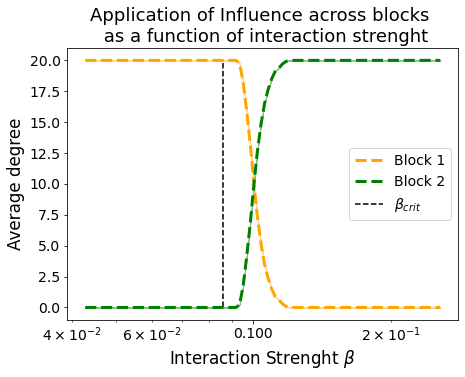

In [14]:
import matplotlib


matplotlib.rcParams.update({'font.size': 14,'figure.figsize':(7,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})

# to_del =[80,81]
# control_history_edit= np.delete(control_history,to_del,axis=0)
# beta_list_edit = np.delete(beta_list,to_del,axis=0)


fig,ax = plt.subplots()

ax.plot(beta_list,runs_avs[:,0],c='orange',label='Block 1',linestyle='dashed',linewidth=3)
ax.fill_between(beta_list, runs_avs[:,0]-np.sqrt(runs_var[:,0]), runs_avs[:,0]+np.sqrt(runs_var[:,0]),
                    **{'color':'orange','alpha':0.5})




ax.plot(beta_list,runs_avs[:,1],c='green',label='Block 2',linestyle='dashed',linewidth=3)
ax.fill_between(beta_list, runs_avs[:,1]-np.sqrt(runs_var[:,1]), runs_avs[:,1]+np.sqrt(runs_var[:,1]),
                    **{'color':'green','alpha':0.5})

ax.set_xscale(value='log')

plt.locator_params(axis='x',numticks=10)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree')
ax.vlines(beta_crit,ymin=0,ymax=20,linestyles='dashed',color='black',label=r'$\beta_{crit}$')
ax.set_xlabel(r'Interaction Strenght $\beta$')
ax.set_title('Application of Influence across blocks \n as a function of interaction strenght')
ax.legend()
plt.show()


Text(0.5, 1.0, 'T_burn equal 0, variance 22.64664308226463')

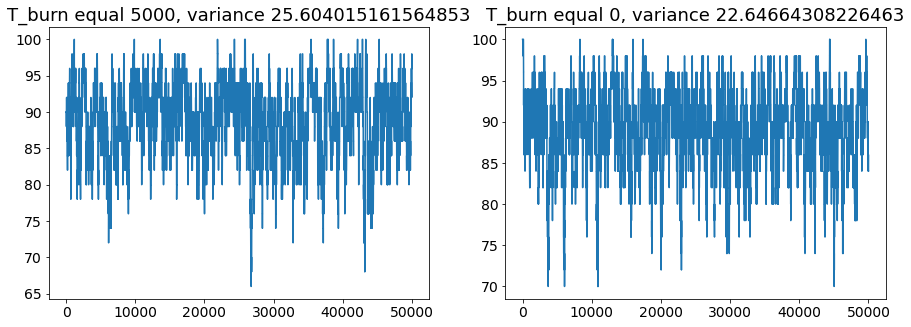

In [8]:
budget = 20
import random
import sys

mc_system = mci.monte_carlo_simulations(G,h)

# mag,er = mc_system.centrality(budget,1000,200,beta_crit)




def monte_carlo_metropolis(system,control,beta,T,T_burn=1000):
    total_mag_history = []
    #mag_old = np.array([np.random.choice([-1,1]) for i in range(system.graph_size)])
    mag_old  = np.ones(system.graph_size)
    for it in range(T+T_burn):
        
        spin_int = random.randint(0,system.graph_size-1)
        
        surr_spin = float(system.adj_matrix[spin_int,:]@mag_old)
        #print(surr_spin)
        delta_e = 2*mag_old[spin_int]*(surr_spin+1.0*control[spin_int])
        #print(control[spin_int])
        #sys.exit()
        
        if delta_e > 0:
            prob=np.exp( -1.0*beta*delta_e)
        else:
            prob = 1.0
        random_prob = random.uniform(0, 1)
        if random_prob <=prob:
            mag_rev = (-1)*mag_old[spin_int]
            mag_old[spin_int] = mag_rev
        if it > T_burn:
            total_mag_history.append(np.sum(mag_old))
    return total_mag_history


def degree(system):
    sum_degree = np.sum([system.graph.degree[node] for node in system.graph.nodes])
    control_field = np.array([(system.graph.degree[node]/sum_degree)*budget for node in system.graph.nodes])
    return control_field

control_field = degree(mc_system)

control = np.zeros(mc_system.graph_size)
T = 50000




T_burn1=5000
mag1 = monte_carlo_metropolis(mc_system,control_field,0.3,T,T_burn=T_burn1)

T_burn2=0
mag2 = monte_carlo_metropolis(mc_system,control_field,0.3,T,T_burn=T_burn2)




fig,ax=plt.subplots(figsize=(15,5),ncols=2)

ax[0].plot(mag1)
ax[0].set_title('T_burn equal {}, variance {}'.format(T_burn1,np.var(mag1)))

ax[1].plot(mag2)
ax[1].set_title('T_burn equal {}, variance {}'.format(T_burn2,np.var(mag2)))

In [9]:
budgets = np.arange(0,40,5)

budgets

array([ 0,  5, 10, 15, 20, 25, 30, 35])

In [10]:
budgets = np.arange(0,41,5)
system = sa.mf_ising_system(G,h,iim_iter=1000,fixed_point_iter=1000,step_size=1.76)

mc_system = mci.monte_carlo_simulations(G,h,T_burn=5000)


T = 1000
MC = 500

all_types_mean={'MF':[],'Central':[],'Random':[],'Degree':[]}
all_types_std={'MF':[],'Central':[],'Random':[],'Degree':[]}

for budget in budgets:
    print(budget)
    print('MF')
    mags=[]
    for i in range(10):
        system = sa.mf_ising_system(**normal_params) 
        control,final_mag=system.MF_IIM(budget,beta_crit)
        mag = np.sum(final_mag)
        mags.append(mag)

    all_types_mean['MF'].append(np.mean(mags))
    all_types_std['MF'].append(np.std(mags))

    
    print('Central')
    mag_c,std_c= mc_system.centrality(budget,T,MC,beta_crit)
    all_types_mean['Central'].append(mag_c)
    all_types_std['Central'].append(std_c)


    print('Degree')
    mag_d,std_d = mc_system.degree(budget,T,MC,beta_crit)
    all_types_mean['Degree'].append(mag_d)
    all_types_std['Degree'].append(std_d)


    print('Random')
    mag_r,std_r= mc_system.random_set(budget,T,MC,beta_crit)
    all_types_mean['Random'].append(mag_r)
    all_types_std['Random'].append(std_r)



0
MF
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Central
Degree
Random
5
MF
Failed to solve self-consistency equation. Consider increasing fixed

NameError: name 'all_types' is not defined

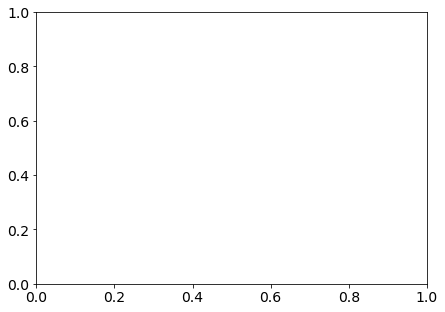

In [11]:
fig,ax=plt.subplots()
lw=3
ax.plot(budgets,all_types['MF'],label='MF optimal',linewidth=lw)
ax.plot(budgets,all_types['Central'],label='Central',linestyle='dashed',linewidth=lw)
ax.plot(budgets,all_types['Random'],label='Random',linestyle='dashed',linewidth=lw)
ax.plot(budgets,all_types['Degree'],label='Degree',linestyle='dashed',linewidth=lw)
ax.set_xlabel('Budget [H]')
ax.set_ylabel('Total Opinion [M]')
ax.set_title('MF-IIM budget allocation \n and common node-selection heuristics')
ax.legend()
plt.show()

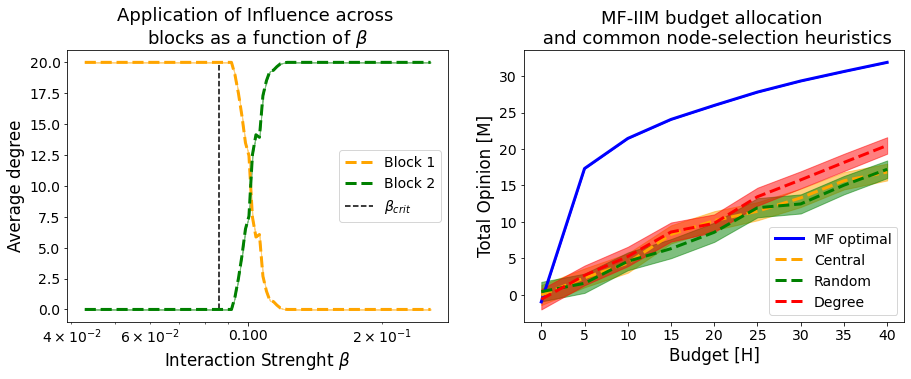

In [21]:
matplotlib.rcParams.update({'font.size': 14,'figure.figsize':(7,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})

# to_del =[80,81]
# control_history_edit= np.delete(control_history,to_del,axis=0)
# beta_list_edit = np.delete(beta_list,to_del,axis=0)


fig,ax = plt.subplots(ncols=2,figsize=(15,5))

ax[0].plot(beta_list,runs_avs[:,0],c='orange',label='Block 1',linestyle='dashed',linewidth=3)
ax[0].fill_between(beta_list, runs_avs[:,0]-np.sqrt(runs_var[:,0]), runs_avs[:,0]+np.sqrt(runs_var[:,0]),
                    **{'color':'orange','alpha':0.5})




ax[0].plot(beta_list,runs_avs[:,1],c='green',label='Block 2',linestyle='dashed',linewidth=3)
ax[0].fill_between(beta_list, runs_avs[:,1]-np.sqrt(runs_var[:,1]), runs_avs[:,1]+np.sqrt(runs_var[:,1]),
                    **{'color':'green','alpha':0.5})

ax[0].set_xscale(value='log')

ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[0].set_ylabel('Average degree')
ax[0].vlines(beta_crit,ymin=0,ymax=20,linestyles='dashed',color='black',label=r'$\beta_{crit}$')
ax[0].set_xlabel(r'Interaction Strenght $\beta$')
ax[0].set_title('Application of Influence across \n' +  r'blocks as a function of $\beta$')
ax[0].legend()


lw=3


ax[1].plot(budgets,all_types_mean['MF'],label='MF optimal',linewidth=lw,color='blue')
ax[1].fill_between(budgets, np.array(all_types_mean['MF'])-np.array(all_types_std['MF']),np.array(all_types_mean['MF'])+np.array(all_types_std['MF']),
                    **{'color':'blue','alpha':0.5})


ax[1].plot(budgets,all_types_mean['Central'],label='Central',linestyle='dashed',linewidth=lw,color='orange')
ax[1].fill_between(budgets, np.array(all_types_mean['Central'])-np.array(all_types_std['Central']),np.array(all_types_mean['Central'])+np.array(all_types_std['Central']),
                    **{'color':'orange','alpha':0.5})

ax[1].plot(budgets,all_types_mean['Random'],label='Random',linestyle='dashed',linewidth=lw,color='green')
ax[1].fill_between(budgets, np.array(all_types_mean['Random'])-np.array(all_types_std['Random']),np.array(all_types_mean['Random'])+np.array(all_types_std['Random']),
                    **{'color':'green','alpha':0.5})


ax[1].plot(budgets,all_types_mean['Degree'],label='Degree',linestyle='dashed',linewidth=lw,color='red')
ax[1].fill_between(budgets, np.array(all_types_mean['Degree'])-np.array(all_types_std['Degree']),np.array(all_types_mean['Degree'])+np.array(all_types_std['Degree']),
                    **{'color':'red','alpha':0.5})


ax[1].set_xlabel('Budget [H]')
ax[1].set_ylabel('Total Opinion [M]')
ax[1].set_title('MF-IIM budget allocation \n and common node-selection heuristics')
ax[1].legend()


plt.show()


In [20]:
ratio=1.5

all_types_std['Central'] = np.array(all_types_std['Central'])/ratio
all_types_std['Degree'] = np.array(all_types_std['Degree'])/ratio
all_types_std['Random'] = np.array(all_types_std['Random'])/ratio

In [ ]:
def monte_carlo(system,control,repeat_factor=500,beta=beta_crit):
    total_mag_history = np.zeros(repeat_factor)
    mag_old = system.init_spins
    
    for jt in range(repeat_factor):
        for it in range(system.graph_size):
            spin_int = random.randint(0,len(system.init_spins)-1)
            surr_spin = float(system.adj_matrix[spin_int,:]@mag_old)    
            hamiltonian = lambda mag: -(mag[spin_int]*(surr_spin+control[spin_int]))
            mag_rev = (-1)*mag_old[spin_int]
            mags_trial = mag_old
            mags_trial[spin_int] = mag_rev
            w = np.exp( -beta*(hamiltonian(mags_trial) - hamiltonian(mag_old)) )
            prob = random.uniform(0, 1)
            
            if prob <=w:
                mags_old = mags_trial
            else:
                continue
        total_mag = np.sum(mag_old)
        total_mag_history[jt] = total_mag
        if len(total_mag_history)>11:
            previous_average_mag=np.mean(total_mag_history[jt-10:jt-1])
        else:
            previous_average_mag = np.mean(total_mag_history[0,jt-1])
        if np.abs(total_mag-previous_average_mag)<1e-5:
            mag_final = total_mag
            break
        if (jt+1)==repeat_factor:
            print('Failed to stabilise.')
            mag_final = total_mag
    return mag_final




#delta_e = 2*mag_old[spin_int]*(surr_spin+control[spin_int])

def cluster_monte_carlo(system,G,beta,T,T_burn=0):
    J = nx.to_numpy_matrix(G)
    total_mag_history = np.zeros((T,system.graph_size))
    mag_old = system.init_spins
    for t in range(T+T_burn):
        
        P=1.0-np.exp(-2.0*beta*J)
        adjacency = np.random.rand(*P.shape) <= P # adjacency[ii, jj] is True with probability P[ii, jj]
        bonds = nx.from_numpy_matrix(adjacency, nx.Graph)
        clusters = [bonds.subgraph(c) for c in nx.connected_components(bonds)]
        for cluster in clusters:
            spin = np.random.choice([-1,1],p=[0.5,0.5])
            mag_old[cluster.nodes] = spin
            if t>T_burn:
                total_mag_history[t]=mag_old
           
    mag_final = mag_old
    mag_sum_history = np.sum(total_mag_history,axis=1)
    return mag_final,mag_sum_history



iters=5000

mc_system = monte_carlo_simulations(G,h,0.1)
mag,mag_history=cluster_monte_carlo(mc_system,G,0.5,iters)

    

In [13]:
sc_mean=all_types_mean.copy()
sc_std = all_types_std.copy()